In [33]:
import copy
import pywt
import math
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib as ta
import tensorflow as tf
from model import Company, StockLog, IndexLog
from model import start_engine
from datetime import date, datetime
from sklearn.preprocessing import MinMaxScaler
from utils import *

%matplotlib inline
warnings.filterwarnings("ignore")

# Read Stock Data

In [34]:
stock = 'ABC'
start = datetime.strptime('2009-07-01', '%Y-%m-%d').date()
finish = datetime.strptime('2019-05-30', '%Y-%m-%d').date()

In [35]:
engine = start_engine()
company = Company().query().get(stock)
stock_log = StockLog().query().filter(StockLog.company==company)
df = pd.read_sql(stock_log.statement, engine)
df.drop(df.columns[[1, 8, 9, 10, 11, 12, 13]], axis=1, inplace=True)
df.rename(columns={'opening': 'open', 'closing': 'close'}, inplace=True)
df.sort_values(by='date', inplace=True)
df.set_index('date', inplace=True)

# Technical Indicators

In [36]:
for period in [15, 50, 200]:
    df['sma%d' % period] = ta.SMA(df['close'], timeperiod=period)
for period in [15, 50, 200]:
    df['ema%d' % period] = ta.EMA(df['close'], timeperiod=period)  
df['macd'], df['macd_sig'], df['macd_hist']  = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['bb_hi'], df['bb_mid'], df['bb_lo'] = ta.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['rsi'] = ta.RSI(df['close'], timeperiod=14)
df['adx'] = ta.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['cci'] = ta.CCI(df['high'], df['low'], df['close'], timeperiod=14)
df['aroon_dn'], df['aroon_up'] = ta.AROON(df['high'], df['low'], timeperiod=25)
df['chaikin'] = ta.AD(df['high'], df['low'], df['close'], df['volume'])
df['obv'] = ta.OBV(df['close'], df['volume'])
df['mom'] = ta.MOM(df['close'], timeperiod=10)

In [ ]:
# for sl in company.stock_logs:
#     print(sl.date, df.loc[sl.date,:])

# Read Fundamental Indicies

In [6]:
sectors = {'Consumer Discretionary': 'discretionary',
           'Consumer Staples': 'staples',
           'Energy': 'energy',
           'Financials': 'financials',
           'Health Care': 'healthcare',
           'Industrials': 'industrials',
           'Information Technology': 'infotech',
           'Materials': 'materials',
           'Telecommunication Services': 'telecom',
           'Utilities': 'utilities',
           'Real Estate': 'realestate'}
sectors_cpy = copy.deepcopy(sectors)
sectors_cpy.pop(company.sector)
sectors_cpy = set([sectors_cpy[sector] for sector in sectors_cpy])

index_log = IndexLog().query()
fi = pd.read_sql(index_log.statement, engine)
indicies = set(fi['index'])
indicies -= sectors_cpy

for idx in indicies:
    new = fi.loc[fi['index'] == idx]
    new = new.rename(columns={'value': idx})
    new.sort_values(by='date', inplace=True)
    new.set_index('date', inplace=True)
    new.drop(new.columns[[0]], axis=1, inplace=True)
    df = df.merge(new, how='outer', left_index=True, right_index=True)
df.rename(columns={sectors[company.sector]: 'sector'}, inplace=True)

In [7]:
df[3000:3005]

,open,high,low,close,adjusted,volume,sma15,sma50,sma200,ema15,...,obv,mom,axvi,prime,asx200,world,aud_usd,pacific,sector,twi
date,,,,,,,,,,,,,,,,,,,,,
2011-06-15,3.06,3.07,3.03,3.04,2.16,848110.0,3.098000,3.1598,3.28750,3.081994,...,-97405595.0,-0.11,16.72,NaN,4566.7998,38.6831,1.0556,32.2551,13228.78,77.7
2011-06-16,3.05,3.07,3.01,3.05,2.17,4974280.0,3.097333,3.1552,3.28655,3.077995,...,-92431315.0,-0.19,19.96,NaN,4479.2002,38.5921,1.0561,31.9632,12922.69,76.9
2011-06-17,3.05,3.09,3.04,3.05,2.17,2552437.0,3.092667,3.1506,3.28525,3.074496,...,-92431315.0,-0.07,20.67,NaN,4484.8999,38.6831,1.0618,32.2273,12922.52,76.8
2011-06-20,3.09,3.09,3.01,3.02,2.15,658239.0,3.086000,3.1456,3.28395,3.067684,...,-93089554.0,-0.11,21.57,NaN,4451.7002,38.8320,1.0578,32.0257,12740.12,76.8
2011-06-21,3.06,3.08,3.04,3.06,2.17,613072.0,3.078667,3.1420,3.28285,3.066723,...,-92476482.0,-0.02,20.03,NaN,4508.2002,39.4938,1.0595,32.5817,12945.75,76.8


# Clean Up

In [8]:
df.drop(df[df.open == 0].index, inplace=True)
df.dropna(subset=['open'], inplace=True)

In [9]:
df['prime'].interpolate(method='pad', inplace=True)
df['world'].interpolate(method='pad', inplace=True)
df['pacific'].interpolate(method='pad', inplace=True)
df['axvi'].interpolate(method='pad', inplace=True)
df['sector'].interpolate(method='pad', inplace=True)
df['aud_usd'].interpolate(method='pad', inplace=True)
df['twi'].interpolate(method='pad', inplace=True)

In [10]:
df.drop(df[df.index < start].index, inplace=True)
df.drop(df[df.index > finish].index, inplace=True)

# Transforming the Data

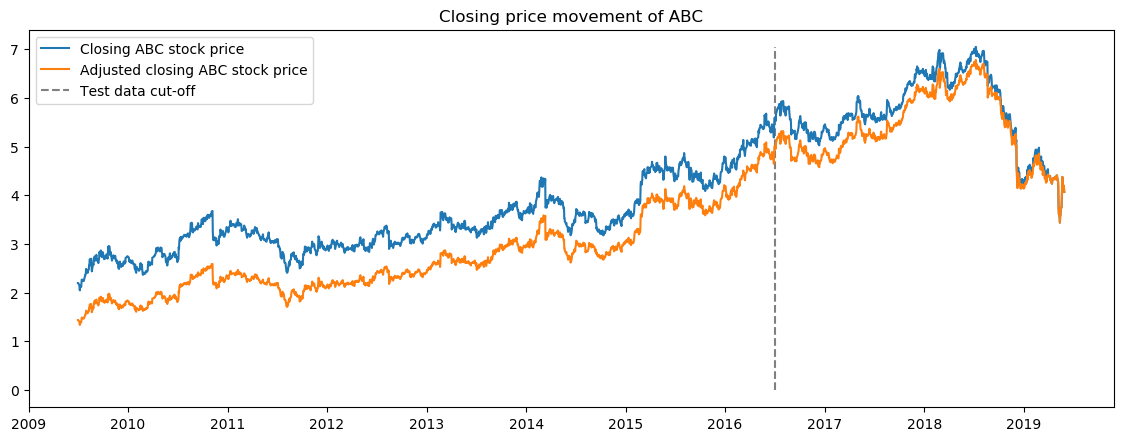

In [11]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df.index, df['close'], label='Closing %s stock price' % stock)
plt.plot(df.index, df['adjusted'], label='Adjusted closing %s stock price' % stock)
plt.vlines(date(2016, 7, 1), 0, df['close'].max(), linestyles='--', colors='gray', label='Test data cut-off')
plt.title('Closing price movement of %s' % stock)
plt.legend()
plt.show()

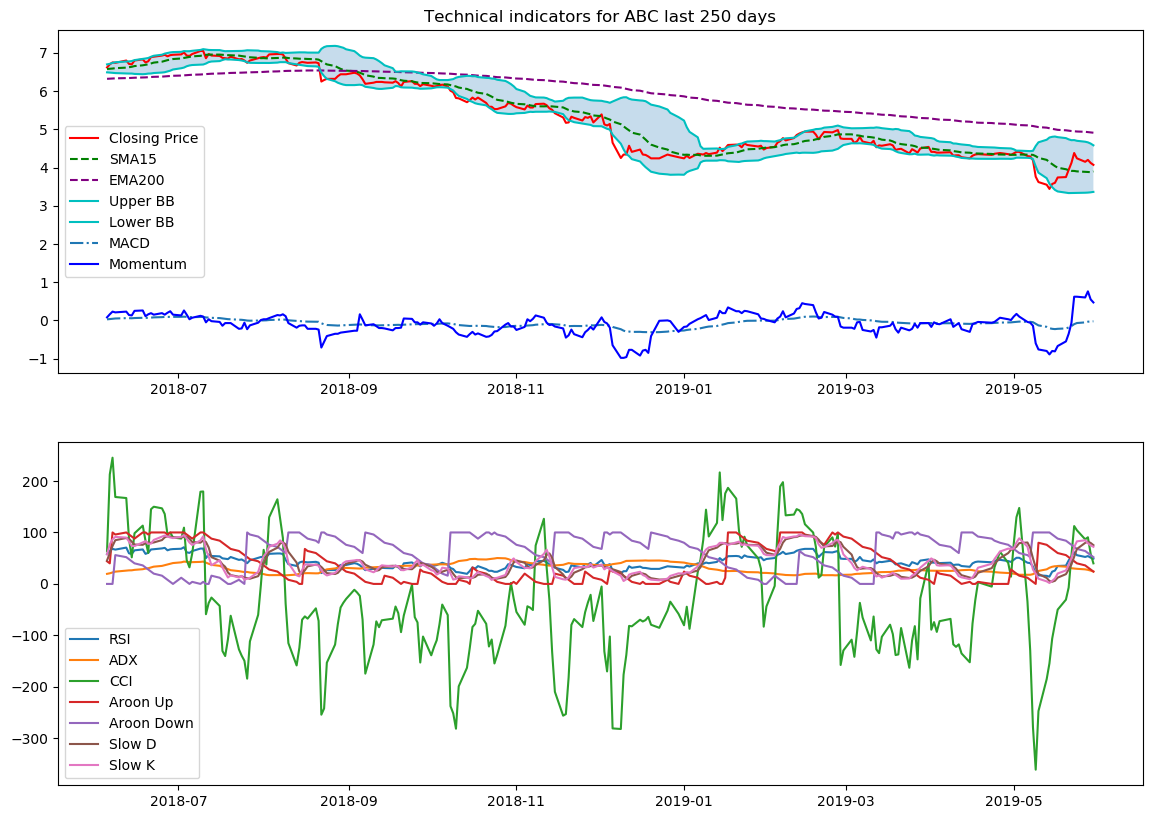

In [12]:
dataset = copy.deepcopy(df)
last_days = 250

plt.figure(figsize=(14, 10), dpi=100)
shape_0 = dataset.shape[0]
xmacd_ = shape_0 - last_days
    
dataset = dataset.iloc[-last_days:, :]
x_ = range(3, dataset.shape[0])
x_ = list(dataset.index)

plt.subplot(2, 1, 1)
plt.plot(dataset['close'], label='Closing Price', color='r')
plt.plot(dataset['sma15'], label='SMA15', color='g',linestyle='--')
plt.plot(dataset['ema200'], label='EMA200', color='purple',linestyle='--')
plt.plot(dataset['bb_hi'], label='Upper BB', color='c')
plt.plot(dataset['bb_lo'], label='Lower BB', color='c')
plt.plot(dataset['macd'],label='MACD', linestyle='-.')
plt.plot(dataset['mom'], label='Momentum', color='b', linestyle='-')
plt.fill_between(x_, dataset['bb_lo'], dataset['bb_hi'], alpha=0.25)
plt.title('Technical indicators for %s last {} days'.format(last_days) % stock)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(dataset['rsi'], label='RSI', linestyle='-')
plt.plot(dataset['adx'], label='ADX', linestyle='-')
plt.plot(dataset['cci'], label='CCI', linestyle='-')
plt.plot(dataset['aroon_up'], label='Aroon Up', linestyle='-')
plt.plot(dataset['aroon_dn'], label='Aroon Down', linestyle='-')
plt.plot(dataset['slowd'], label='Slow D', linestyle='-')
plt.plot(dataset['slowk'], label='Slow K', linestyle='-')
plt.legend()

plt.show()

In [13]:
data_FT = df[['close']]
close_fft = np.fft.fft(np.asarray(data_FT['close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
fft_list = np.asarray(fft_df['fft'].tolist())
x = data_FT['close']
tx = np.fft.ifft(fft_list)
print('Signal noise: ', x.mean()/x.std())
print('Transform noise: ', tx.mean()/tx.std())

Signal noise:  3.312537737712079
Transform noise:  (3.3131988569158897+2.886238663799072e-17j)


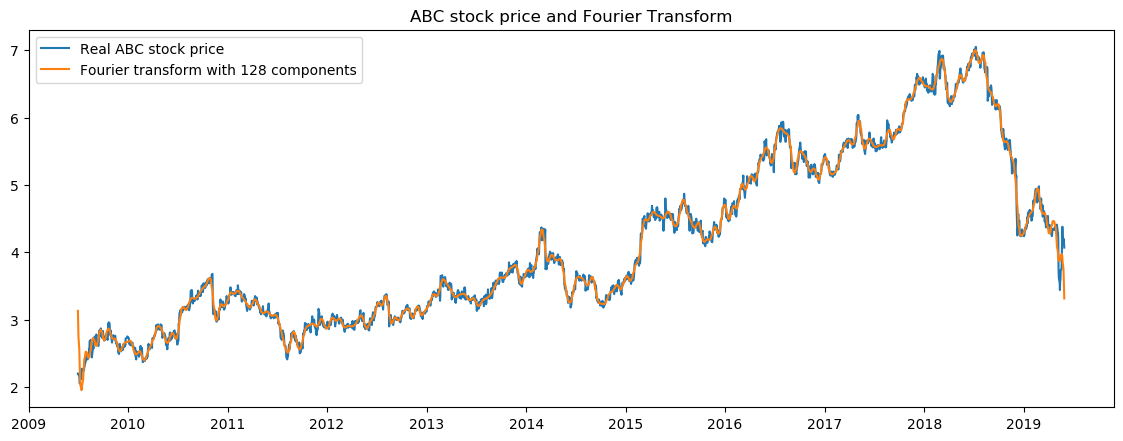

In [14]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data_FT.index, data_FT['close'], label='Real %s stock price' % stock)
fft_list[128:-128] = 0
plt.plot(data_FT.index, np.fft.ifft(fft_list), label='Fourier transform with 128 components')
plt.title('%s stock price and Fourier Transform' % stock)
plt.legend()
plt.show()

In [15]:
x = np.array(df.iloc[:, 3])
cA4, cD4, cD3, cD2, cD1 = pywt.wavedec(x, 'haar', level=4)
cA4 = pywt.threshold(cA4, np.std(cA4), mode="hard")
cD4 = pywt.threshold(cD4, np.std(cD4), mode="hard") 
cD3 = pywt.threshold(cD3, np.std(cD3), mode="hard") 
cD2 = pywt.threshold(cD2, np.std(cD2), mode="hard") 
cD1 = pywt.threshold(cD1, np.std(cD1), mode="hard") 
tx = pywt.waverec((cA4, cD4, cD3, cD2, cD1), 'haar')
df['dwt'] = tx
print('Signal noise: ', x.mean()/x.std())
print('Transform noise: ', tx.mean()/tx.std())

Signal noise:  3.3131988569158906
Transform noise:  3.3154702949918713


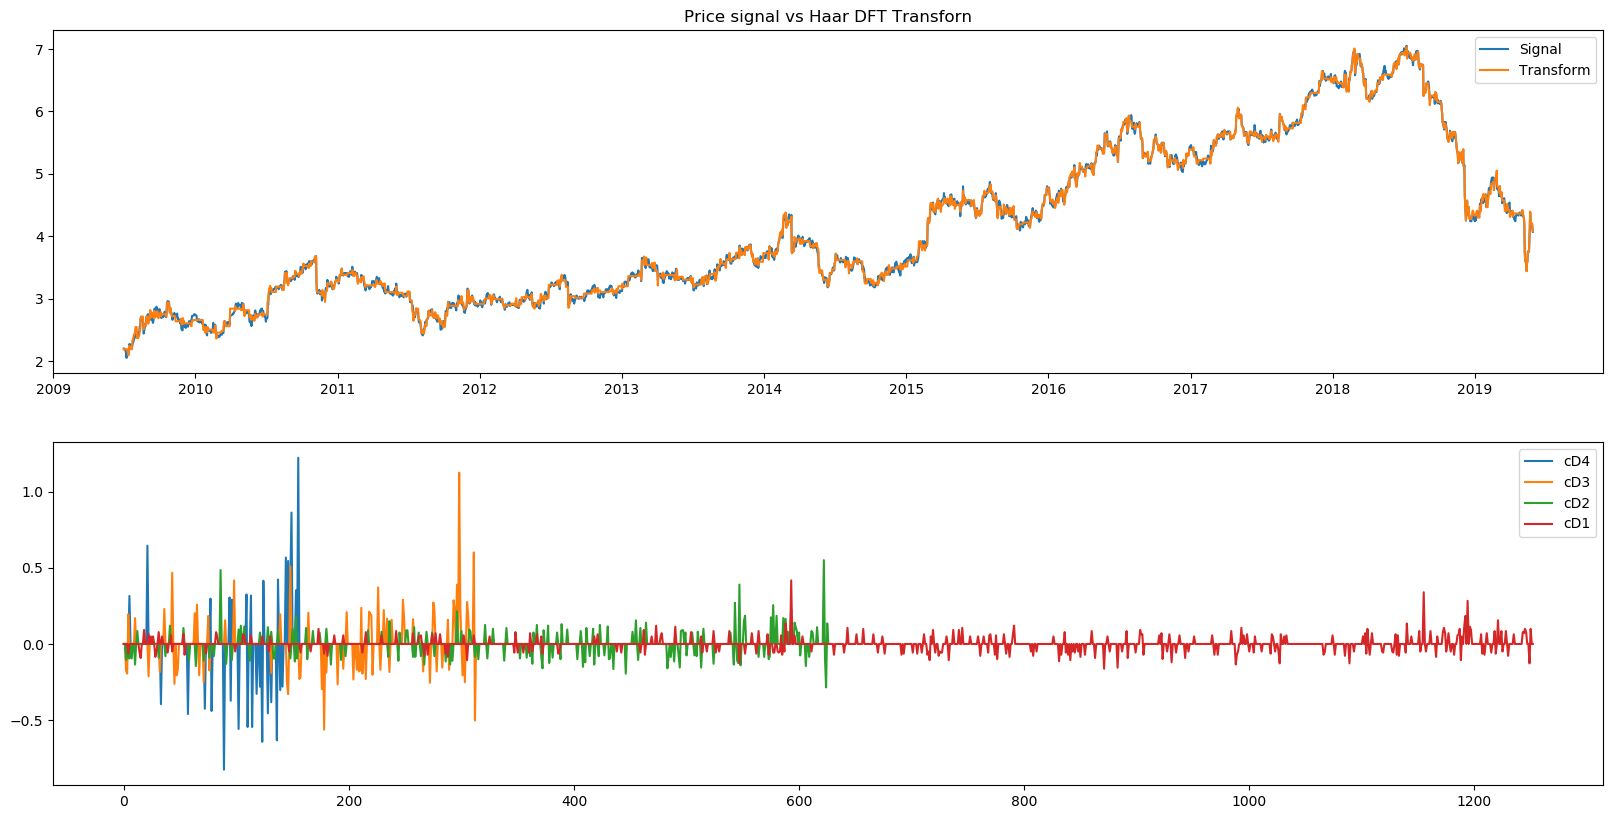

In [16]:
plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(df.index, x, label='Signal')
plt.plot(df.index, tx, label='Transform')
plt.title('Price signal vs Haar DFT Transforn')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(cD4, label='cD4')
plt.plot(cD3, label='cD3')
plt.plot(cD2, label='cD2')
plt.plot(cD1, label='cD1')
plt.legend()
plt.show()

In [17]:
corr = df.iloc[:, 5:-1].corr()

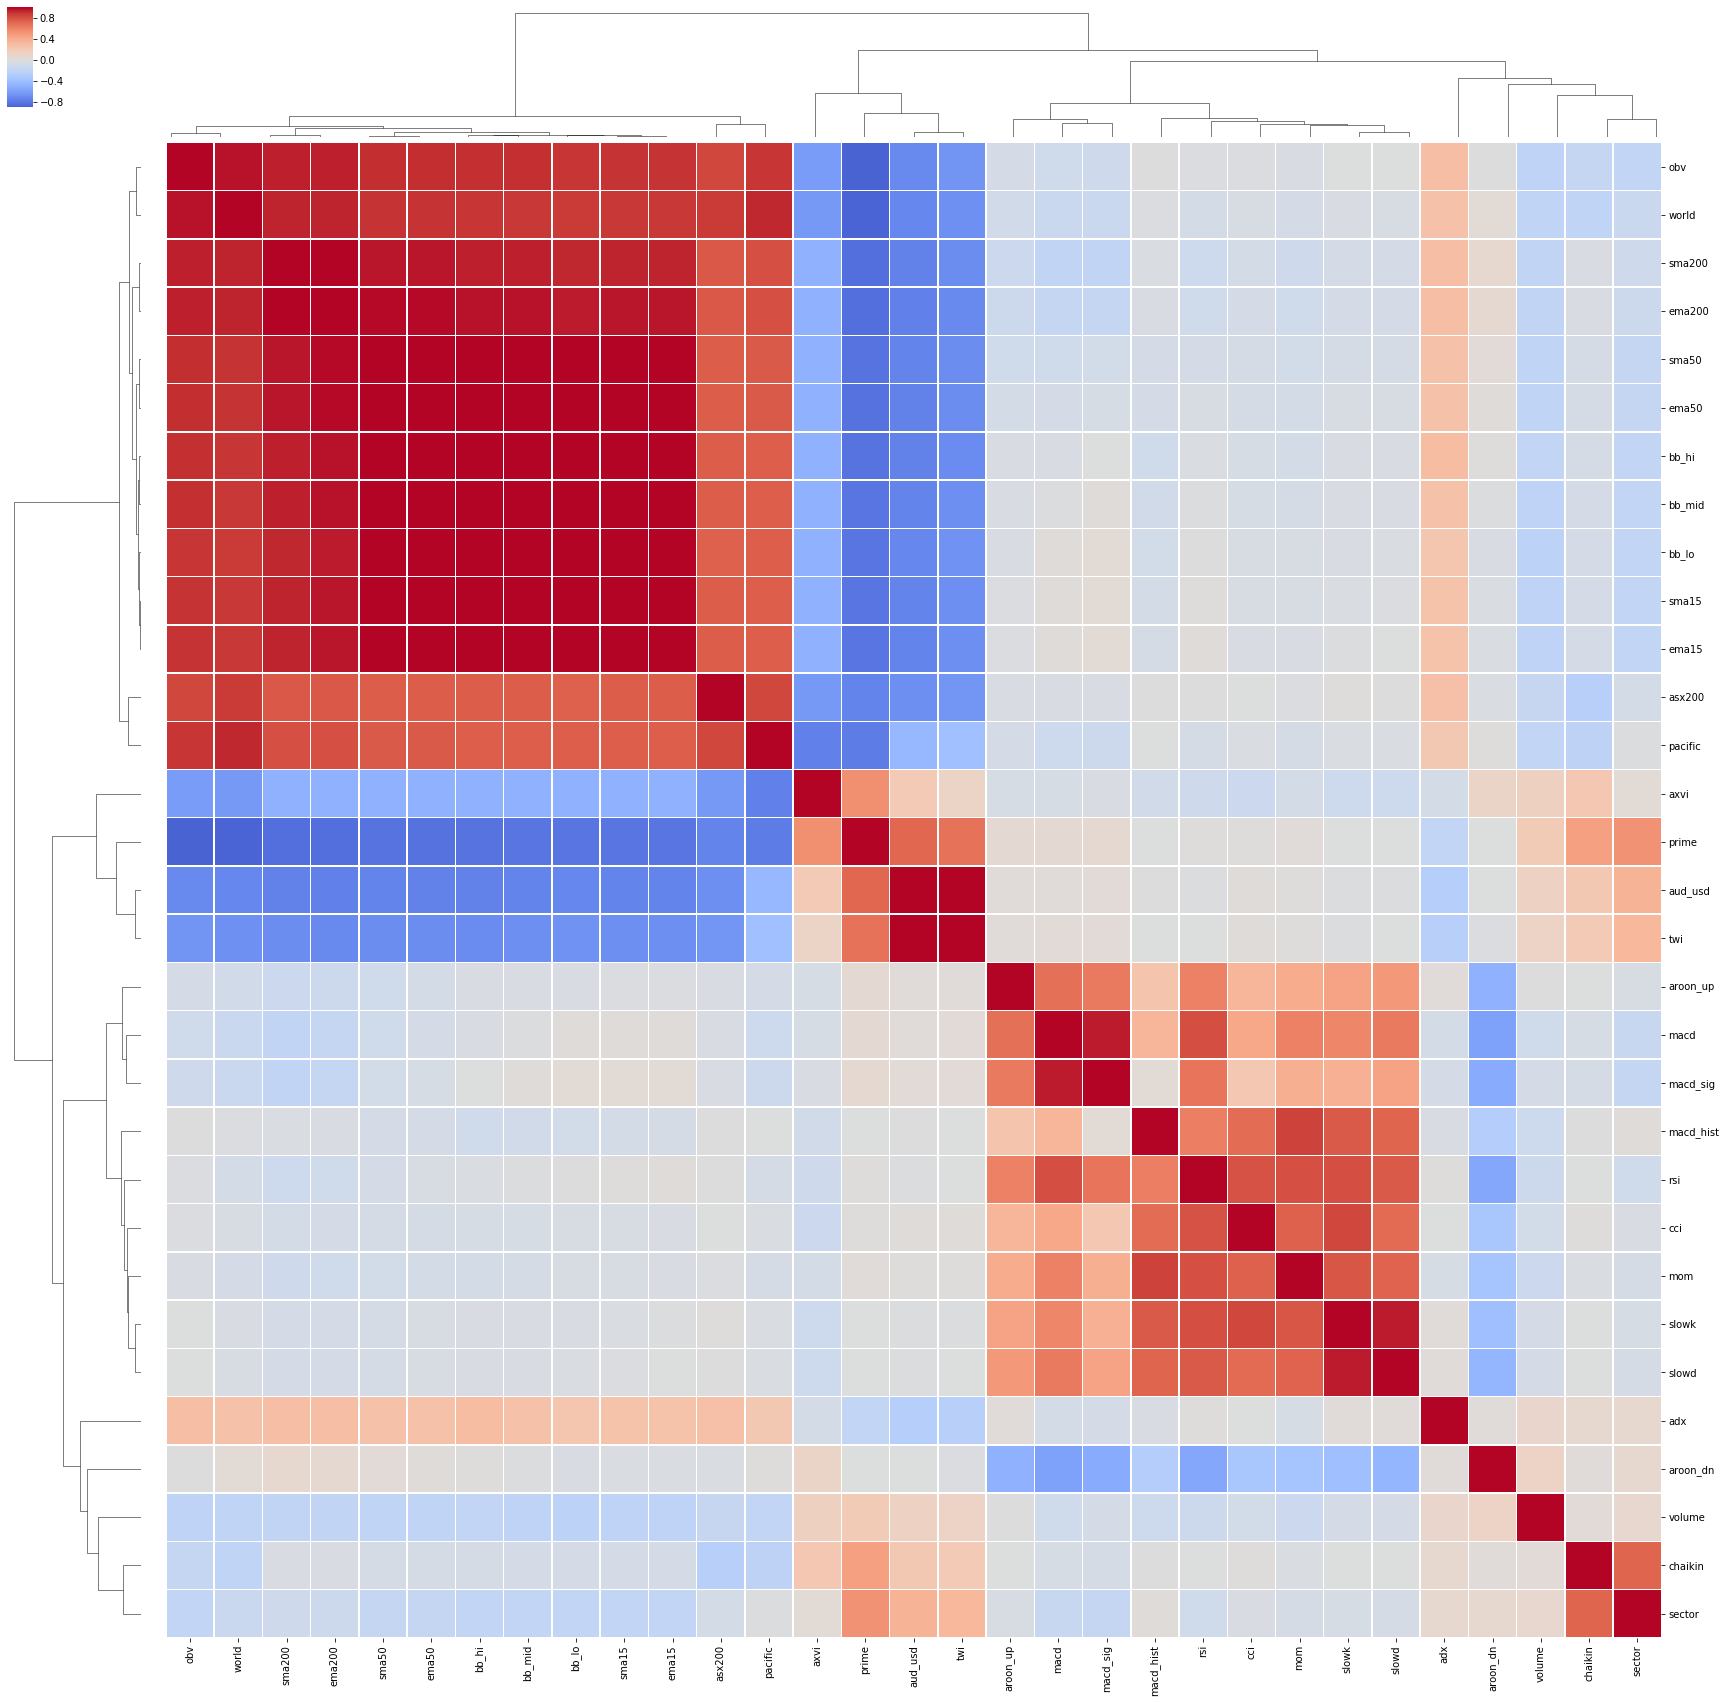

In [18]:
plot = sns.clustermap(corr, cmap='coolwarm', center=0, square=True, linewidths=.5, figsize=(30, 30))
plot.savefig("clustermap.png")
plt.show()

# Predictor

In [19]:
df['dwt'] = df['dwt'].shift(-1)
df['close'] = df['close'].shift(-1)
df.drop(df.columns[[0, 1, 2, 4]], axis=1, inplace=True)
df.dropna(inplace=True)
df = df[5:]

In [20]:
# Data split
data = df.values
train_start = 0
train_end = int(np.floor(0.8 * df.shape[0]))
test_start = train_end
test_end = df.shape[0]
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [21]:
# Scaling
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [22]:
# Set variables
X_train = data_train[:, 1:-1]
y_train = data_train[:, -1]
X_test = data_test[:, 1:-1]
y_test = data_test[:, -1]

In [23]:
# Model hypers
n_feats = 31
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_target = 1
epochs = 25
batch_size = 10

In [24]:
# Placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, n_feats])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [25]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [26]:
# Weights
W_hidden_1 = tf.Variable(weight_initializer([n_feats, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [27]:
# Layers
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

In [28]:
# Init
net = tf.InteractiveSession()
mse = tf.reduce_mean(tf.squared_difference(out, Y))
opt = tf.train.AdamOptimizer().minimize(mse)
net.run(tf.global_variables_initializer())
mse_train = []
mse_test = []

In [29]:
for e in range(epochs):
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        if np.mod(i, 50) == 0:
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('Epoch: ', e+1, '\tMSE Train: ', mse_train[-1], '\tMSE Test: ', mse_test[-1])
            pred = net.run(out, feed_dict={X: X_test})

Epoch:  1 	MSE Train:  0.047837455 	MSE Test:  0.09039663
Epoch:  1 	MSE Train:  0.0013831507 	MSE Test:  0.0047236015
Epoch:  1 	MSE Train:  0.0005138934 	MSE Test:  0.0034115433
Epoch:  1 	MSE Train:  0.0005134717 	MSE Test:  0.0020883284
Epoch:  2 	MSE Train:  0.000534893 	MSE Test:  0.0026207066
Epoch:  2 	MSE Train:  0.0006124339 	MSE Test:  0.0017542402
Epoch:  2 	MSE Train:  0.0007191707 	MSE Test:  0.0012250631
Epoch:  2 	MSE Train:  0.00043851996 	MSE Test:  0.002270559
Epoch:  3 	MSE Train:  0.00034527917 	MSE Test:  0.0016851523
Epoch:  3 	MSE Train:  0.00041746258 	MSE Test:  0.0019888002
Epoch:  3 	MSE Train:  0.0004909656 	MSE Test:  0.0023172875
Epoch:  3 	MSE Train:  0.00079316995 	MSE Test:  0.0013471408
Epoch:  4 	MSE Train:  0.00050499605 	MSE Test:  0.0022923455
Epoch:  4 	MSE Train:  0.00041380417 	MSE Test:  0.00233534
Epoch:  4 	MSE Train:  0.00079482835 	MSE Test:  0.004783614
Epoch:  4 	MSE Train:  0.00057771197 	MSE Test:  0.0021295336
Epoch:  5 	MSE Train:  0

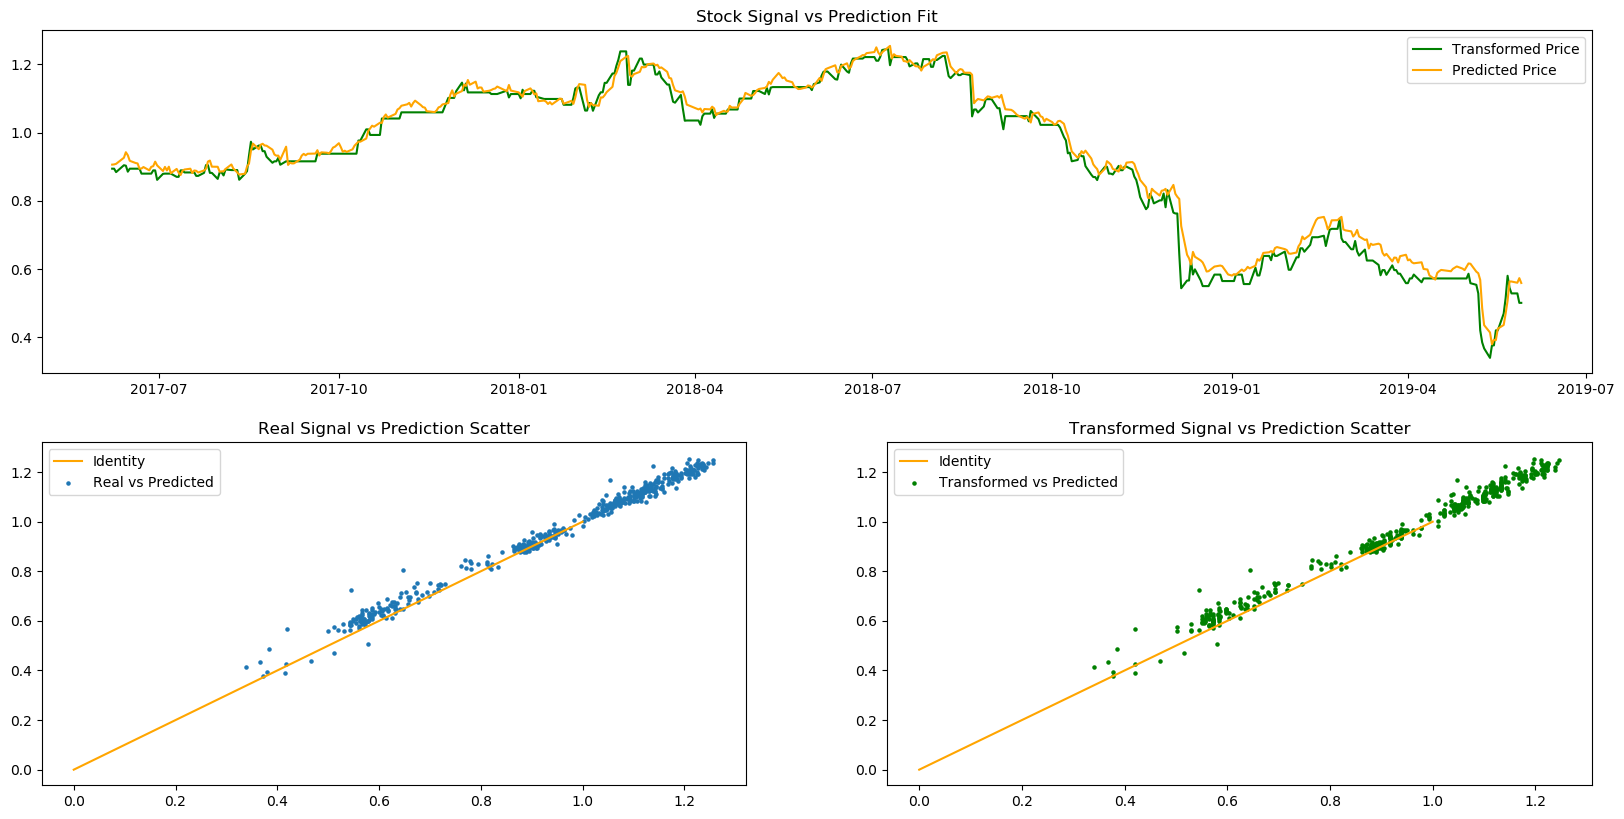

In [35]:
real = 0

plt.figure(figsize=(20, 10), dpi=100)
plt.subplot(2, 1, 1)
if real:
    plt.plot(df[test_start:].index, data_test[:, 0], label='Real Price')
else:
    plt.plot(df[test_start:].index, y_test, label='Transformed Price', c='g')
plt.plot(df[test_start:].index, pred[0], label='Predicted Price', c='orange')
plt.title('Stock Signal vs Prediction Fit')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot([0, 1], [0, 1], c='orange', label='Identity')
plt.scatter(data_test[:, 0], pred[0], label="Real vs Predicted", s=5)
plt.title('Real Signal vs Prediction Scatter')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot([0, 1], [0, 1], c='orange', label='Identity')
plt.scatter(y_test, pred[0], label="Transformed vs Predicted", s=5, c='g')    
plt.title('Transformed Signal vs Prediction Scatter')
plt.legend()

plt.show()